# Variational Sparse Heteroscedastic Gaussian Process Regression

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VSHGPRegression
from kernels import RBF
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import japanize_matplotlib

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
# x=±πでデータの密度が最大になり、x=0や両端で密度が小さくなるようにする
X = torch.cat([(torch.randn(50) - 3) / 3 * np.pi, (torch.randn(50) + 3) / 3 * np.pi])
# xが大きくなるほど、ノイズが大きくなるようにする
y = X.sin() + torch.randn(100) * (X + 8) / 64

X = X.unsqueeze(1)
y = y.unsqueeze(1)

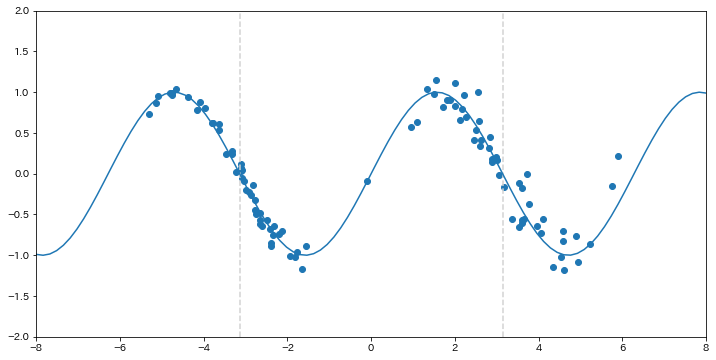

In [7]:
plt.figure(figsize = (12, 6))
plt.axvline(x = -np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
plt.axvline(x = +np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
plt.plot(np.linspace(-8, 8, 100), np.sin(np.linspace(-8, 8, 100)))
plt.scatter(X[:, 0], y[:, 0])
plt.xlim(-8, 8)
plt.ylim(-2, 2)
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

kernel_f = RBF()
kernel_r = RBF()
Z = X[::10, ].clone()
estimator = VSHGPRegression(Z, 1, kernel_f, kernel_r, whiten = True)

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 2000
for epoch in range(n_epochs):
    loss = svi.step(X, y)
    if epoch % (n_epochs / 10) == 0:
        print(loss)

608.4822303641523
127.82874728638215
106.70836502979154
76.27244381195436
56.2428306110499
17.698017214085667
0.7341400367562301
-9.504235556927767
-2.3665985998378005
-19.122329697123064


---

## 推論結果

### 予測分布

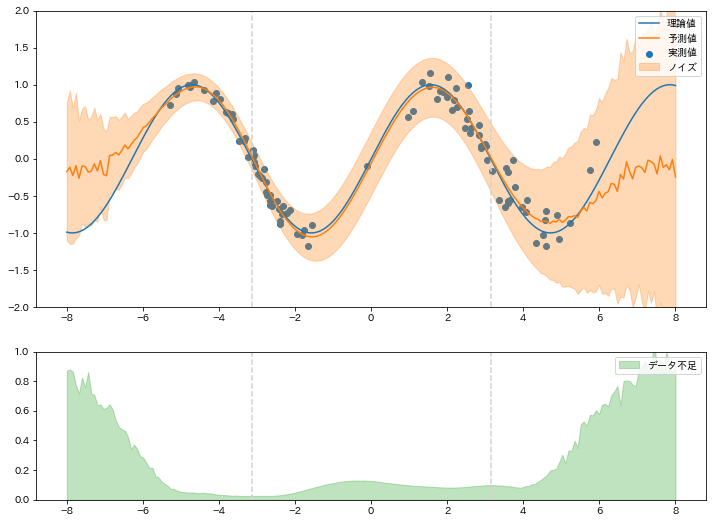

CPU times: user 3.21 s, sys: 308 ms, total: 3.51 s
Wall time: 1.33 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.linspace(-8, 8, 200).unsqueeze(1)
    fnew, rnew = estimator(Xnew, 100)
    fnew_mean = fnew.mean(axis = 0)
    fnew_std = fnew.std(axis = 0)
    rnew_mean = rnew.mean(axis = 0)
    rnew_std = rnew.std(axis = 0)

    fig, axs = plt.subplots(2, 1, figsize = (12, 9), gridspec_kw = {"height_ratios": [2, 1]})

    axs[0].axvline(x = -np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
    axs[0].axvline(x = +np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
    axs[0].plot(Xnew[:, 0], Xnew.sin()[:, 0], color = "C0", label = "理論値")
    axs[0].scatter(x = X[:, 0], y = y[:, 0], color = "C0", label = "実測値")
    axs[0].plot(Xnew.numpy(), fnew_mean.numpy(), color = "C1", label = "予測値")
    axs[0].fill_between(
        Xnew[:, 0],
        (fnew_mean - 2.0 * rnew_mean)[:, 0],
        (fnew_mean + 2.0 * rnew_mean)[:, 0],
        color = "C1", alpha = 0.3,
        label = "ノイズ"
    )
    axs[0].legend()
    axs[0].set_ylim(-2, 2)

    axs[1].axvline(x = -np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
    axs[1].axvline(x = +np.pi, ymin = 0, ymax = 1, linestyle = "--", color = "lightgray")
    axs[1].fill_between(
        Xnew[:, 0],
        0,
        fnew_std[:, 0],
        color = "C2", alpha = 0.3,
        label = "データ不足"
    )
    axs[1].legend()
    axs[1].set_ylim(0, 1)

    plt.show()

### ハイパーパラメーター

In [10]:
estimator.gp_f.kernel.scale

tensor(1.8817, grad_fn=<AddBackward0>)

In [11]:
estimator.gp_r.kernel.scale

tensor(2.4460, grad_fn=<AddBackward0>)

In [12]:
estimator.gp_r.likelihood.mu.exp()

tensor([[0.5021]], grad_fn=<ExpBackward>)

### 変分パラメーター

In [13]:
estimator.gp_f.Z

Parameter containing:
tensor([[-1.7378],
        [-3.0171],
        [-2.6817],
        [-2.1876],
        [-4.9106],
        [ 3.2050],
        [ 2.9177],
        [ 1.5495],
        [ 2.3265],
        [ 0.8271]], requires_grad=True)

In [14]:
estimator.gp_f.u_loc

Parameter containing:
tensor([[-1.0327,  1.1852, -1.3697, -0.6038, -0.4394, -0.1141,  1.8042,  0.2507,
          0.4020,  0.4525]], requires_grad=True)

In [15]:
estimator.gp_f.u_cov

tensor([[[ 4.3805e-03, -6.8803e-03, -1.0849e-02,  7.1908e-03, -1.6394e-02,
           5.6153e-04,  7.3616e-04, -9.1895e-03,  1.2471e-02, -6.7217e-03],
         [-6.8803e-03,  1.2666e-02,  2.0768e-02, -1.5895e-02,  3.3827e-02,
          -1.5815e-03, -3.7315e-03,  1.3875e-02, -2.2823e-02,  1.3517e-02],
         [-1.0849e-02,  2.0768e-02,  6.1766e-02,  1.3285e-02,  6.5392e-02,
          -2.8745e-03,  3.2872e-03,  7.5303e-02, -8.2355e-02,  1.8443e-02],
         [ 7.1908e-03, -1.5895e-02,  1.3285e-02,  1.8275e-01, -1.2906e-01,
           2.7216e-02,  8.3846e-02,  1.9983e-01, -6.0020e-02, -3.2656e-02],
         [-1.6394e-02,  3.3827e-02,  6.5392e-02, -1.2906e-01,  2.1320e-01,
          -2.8822e-02, -7.2068e-02, -8.6976e-02, -4.9117e-02,  5.2982e-02],
         [ 5.6153e-04, -1.5815e-03, -2.8745e-03,  2.7216e-02, -2.8822e-02,
           1.3656e-02,  1.5123e-02,  1.4143e-02, -3.6223e-02,  1.0081e-02],
         [ 7.3616e-04, -3.7315e-03,  3.2872e-03,  8.3846e-02, -7.2068e-02,
           1.5123e-

In [16]:
estimator.gp_r.Z

Parameter containing:
tensor([[-1.9377],
        [-3.1546],
        [-2.5196],
        [-2.2627],
        [-5.0291],
        [ 3.6703],
        [ 3.1249],
        [ 1.4950],
        [ 2.6160],
        [ 1.0524]], requires_grad=True)

In [17]:
estimator.gp_r.u_loc

Parameter containing:
tensor([[-1.3343, -1.1413,  0.5858,  0.4091,  0.0939, -0.5081, -0.6206,  0.0685,
          0.5989,  0.4982]], requires_grad=True)

In [18]:
estimator.gp_r.u_cov

tensor([[[ 0.0540, -0.0717, -0.0130,  0.0745,  0.0729,  0.0060, -0.0108,
          -0.0225,  0.0182, -0.0017],
         [-0.0717,  0.1881,  0.0972, -0.2076, -0.1568, -0.0070,  0.0367,
           0.0685, -0.0371,  0.0315],
         [-0.0130,  0.0972,  0.3239, -0.0789,  0.0615,  0.0495,  0.1934,
           0.1676, -0.0191,  0.0538],
         [ 0.0745, -0.2076, -0.0789,  0.7456,  0.0499,  0.1008,  0.1659,
           0.0872,  0.0440, -0.0441],
         [ 0.0729, -0.1568,  0.0615,  0.0499,  0.7570, -0.0053,  0.0101,
           0.0267,  0.0467, -0.0013],
         [ 0.0060, -0.0070,  0.0495,  0.1008, -0.0053,  0.0954,  0.0114,
          -0.0807, -0.1072, -0.0242],
         [-0.0108,  0.0367,  0.1934,  0.1659,  0.0101,  0.0114,  0.4395,
           0.1854,  0.2974,  0.1790],
         [-0.0225,  0.0685,  0.1676,  0.0872,  0.0267, -0.0807,  0.1854,
           0.8056, -0.0529, -0.1029],
         [ 0.0182, -0.0371, -0.0191,  0.0440,  0.0467, -0.1072,  0.2974,
          -0.0529,  0.9939, -0.0159],
 